# Tutorial on Fairness in Recommender System

In this notebook, we become familiar with the recommender system, bias in recommendation engine, and Python recommendation toolbox, in the simplest possible way. First, we introduce the prileminary concepts. Then, we go through the experimental pipeline, by:

- Loading the Movielens 1M dataset;
- Performing a train-test splitting;
- Creating a pairwise / random / mostpop recommendation object;
- Training the model (if applicable);
- Computing the user-item relevance matrix;
- Calculating some of the recommendation metrics (e.g., NDCG, Item Coverage, Diversity, Novelty).

The trained models, together with the partial computation we will save (e.g., user-item relevance matrix or metrics), will be the starting point of the investigation and the treatment covered by the **Bias Analysis** part.

**<font color='red'>IMPORTANT</font>**: _Please go the "Runtime" option in the top menu, then click on "Change runtime" and select "GPU"._

## Intro to Recommender System

<center>
<img src="../content/intro_recsys.png" alt="Introduction to Recommender System" style="width: 400px;"/>
</center>

- Three main components in a **typical recommendation system**
    - data for learning model parameters
    - learning of recommendation models based on the collected data and providing recommendations to users
    - collecting data from users feedback
- Feedback loop, an essential nature of recommendation system 

## Setup the working environment

We will clone the project repository in our Google Colab folder. If you wish to change the target folder, please modify the command below.

In [1]:
! git clone https://github.com/rahmanidashti/FairnessRecSysTutorial.git

Cloning into 'FairnessRecSysTutorial'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 194 (delta 51), reused 167 (delta 33), pack-reused 0
Receiving objects: 100% (194/194), 11.39 MiB | 10.06 MiB/s, done.
Resolving deltas: 100% (51/51), done.


We will move to the project folder in order to install the required packages.

In [2]:
%cd FairnessRecSysTutorial/

/Users/saeed/Documents/GitHub/FairnessRecSysTutorial/notebooks/FairnessRecSysTutorial


In [3]:
! ls

LICENSE.md       data             models           requirements.txt
README.md        helpers          notebooks


We will configure the notebooks directory as our working directory in order to simulate a local notebook execution.

In [4]:
%cd ./notebooks

/Users/saeed/Documents/GitHub/FairnessRecSysTutorial/notebooks/FairnessRecSysTutorial/notebooks


## Import packages

In [5]:
import sys
import os

sys.path.append(os.path.join('..'))

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from helpers.train_test_splitter import *
from models.pointwise import PointWise
from models.pairwise import PairWise
from models.mostpop import MostPop
from models.random import Random
from helpers.utils import *

We will define the folders where we will store our pre-computed results.

In [7]:
data_path = '../data/'

In [8]:
!mkdir '../data/outputs/splits'
!mkdir '../data/outputs/instances'
!mkdir '../data/outputs/models'
!mkdir '../data/outputs/predictions'

## Load data

First, we will load the **Movielens 1M** dataset, which has been pre-arranged in order to comply with the following structure: `user_id, item_id, rating, timestamp, type (label for the item category), and type_id (unique id of the item category)`. For the sake of tutorial easiness, we assume here that each item is randomly assigned to one of its categories in the original dataset. Our toolbox is flexible enough to integrate any other dataset in csv format that has the same structure of the pre-arranged csv shown below. No further changes are needed to experiment with other datasets.   

In [9]:
dataset = 'ml1m'
user_field = 'user_id'
item_field = 'item_id'
rating_field = 'rating'
time_field = 'timestamp'
type_field = 'type_id'

In [10]:
data = pd.read_csv(os.path.join(data_path, 'datasets/' + dataset + '.csv'), encoding='utf8')

In [11]:
data.head()

,user_id,item_id,rating,timestamp,type,type_id
0,1,1193,5.0,2000-12-31 23:12:40,Drama,7
1,2,1193,5.0,2000-12-31 22:33:33,Drama,7
2,12,1193,4.0,2000-12-31 00:49:39,Drama,7
3,15,1193,4.0,2000-12-30 19:01:19,Drama,7
4,17,1193,5.0,2000-12-30 07:41:11,Drama,7


During this tutorial, we will simulate a scenario with implicit feedback (interaction only).

In [14]:
data[rating_field] = data[rating_field].apply(lambda x: 1.0)

In [15]:
data.head()

,user_id,item_id,rating,timestamp,type,type_id
0,1,1193,1.0,2000-12-31 23:12:40,Drama,7
1,2,1193,1.0,2000-12-31 22:33:33,Drama,7
2,12,1193,1.0,2000-12-31 00:49:39,Drama,7
3,15,1193,1.0,2000-12-30 19:01:19,Drama,7
4,17,1193,1.0,2000-12-30 07:41:11,Drama,7


## Split data in train and test sets

- **smode**: 'uftime' for fixed timestamp split, 'utime' for time-based split per user, 'urandom' for random split per user
- **train_ratio**: percentage of data to be included in the train set
- **min_train**: minimum number of train samples for a user to be included  
- **min_test**: minimum number of test samples for a user to be included
- **min_time**: start timestamp for computing the splitting timestamp (only for uftime)
- **max_time**: end timestamp for computing the splitting timestamp (only for uftime)
- **step_time**: timestamp step for computing the splitting timestamp (only for uftime)

In [16]:
smode = 'utime'
train_ratio = 0.80
min_train_samples = 8
min_test_samples = 2
min_time = None
max_time = None
step_time = 1000

During this tutorial, we will work with a common time-based split per user.

In [17]:
if smode == 'uftime':
    traintest = fixed_timestamp(data, min_train_samples, min_test_samples, min_time, max_time, step_time, user_field, item_field, time_field, rating_field)
elif smode == 'utime':
    traintest = user_timestamp(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field, time_field)
elif smode == 'urandom':
    traintest = user_random(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field)

> Parsing user 6000 of 6040


Please note that `user_ids` and `item_id`s have been scaled so that user_ids is in `[0, no_users]` and item_ids will be in `[0, no_items]`. If you wish to link these new ids to the older ones, please refer to the `user_id_original` and `item_id_original` columns.

In [18]:
traintest.head()

,user_id,item_id,rating,timestamp,type,type_id,set,user_id_original,item_id_original
34073,0,2969,1.0,2000-12-31 23:00:19,Drama,7,train,1,3186
31152,0,1574,1.0,2000-12-31 23:00:55,Romance,13,train,1,1721
37339,0,957,1.0,2000-12-31 23:00:55,Children's,3,train,1,1022
23270,0,1178,1.0,2000-12-31 23:00:55,Sci-Fi,14,train,1,1270
28157,0,2147,1.0,2000-12-31 23:01:43,Romance,13,train,1,2340


For the sake of replicability and efficiency of this tutorial, we will save the pre-computed train and test sets in `./data/outputs/splits`

In [19]:
traintest.to_csv(os.path.join(data_path, 'outputs/splits/' + dataset + '_' + smode + '.csv'))

## Run the model train and test

We will create two dataframes, one with `train feedback` and another with `test feedback`, from the pre-computed split data.

In [20]:
train = traintest[traintest['set']=='train'].copy()
test = traintest[traintest['set']=='test'].copy()

In [21]:
users = list(np.unique(traintest[user_field].values))
items = list(np.unique(traintest[item_field].values))

In [22]:
len(users), len(items)

(6040, 3706)

In [23]:
category_per_item = traintest.drop_duplicates(subset=['item_id'], keep='first')[type_field].values

In [24]:
len(np.unique(category_per_item))

18

For the sake of easiness, we will focus on four main recommendation strategies:
- Random
- MostPop
- PairWise

In [26]:
model_types = {'random': Random, 'mostpop': MostPop, 'pairwise': PairWise}

First, we need to initialize the model. We will see how the process works for a PairWise algorithm. Then, we will consider the other ones.

In [27]:
model_type = 'pairwise'
model = PairWise(users, items, train, test, category_per_item, item_field, user_field, rating_field)

Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics


We will train the model by feeding the train data we previously prepared, with the following default values.

- **no_epochs** (default: 100)
- **batches** (default: 1024)
- **lr** (default: 0.001)
- **no_factors** (default: 10)
- **no_negatives** (default: 10)
- **val_split** (default: 0.0001)

In [28]:
model.train(no_epochs=5) # For the sake of tutorial efficiency, we force to stop after 5 epochs

Generating training instances of type pair
Computing instances for interaction 800000 / 803798 of type pair


Performing training - Epochs 5 Batch Size 1024 Learning Rate 0.001 Factors 10 Negatives 10 Mode pair
7772/7772 [==============================] - 8s 1ms/step - loss: 0.1924
Validation accuracy: 0.8587642654466819 (Sample 80000 of 80380)
Epoch 2/2
7772/7772 [==============================] - 8s 1ms/step - loss: 0.1305
Epoch 3/3
7772/7772 [==============================] - 8s 1ms/step - loss: 0.1100
Epoch 4/4
7772/7772 [==============================] - 8s 1ms/step - loss: 0.0990
Epoch 5/5
7772/7772 [==============================] - 8s 1ms/step - loss: 0.0905
Validation accuracy: 0.9162260471744104 (Sample 80000 of 80380)


The architecture of the trained model looks as follows.

In [29]:
model.print()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 UserInput (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 PosItemInput (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 NegItemInput (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 UserEmb (Embedding)         (None, 1, 10)                60410     ['UserInput[0][0]']           
                                                                                              

## Compute user-item relevance scores

Now, we will use the pre-trained model to predict the user-item relevance scores.

In [30]:
model.predict()

Computing predictions for user 6000 / 6040

In [31]:
scores = model.get_predictions()

As we expected, the predicted scores are stored in a matrix of shape np_users x no_items.

In [32]:
scores.shape

(6040, 3706)

Hence, we can access to the relevance score of the user 120 for the item 320 as follows.

In [33]:
user_id, item_id = 120, 320
scores[user_id, item_id]

4.5636725425720215

For the sake of convenience, we will save the predicted scores.

In [34]:
save_obj(scores, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + smode + '_' + model_type + '_scores.pkl'))

## Calculate metrics

In this step, we leverage the predicted scores in order to compute a set of common recommendation metrics.

In [35]:
cutoffs = np.array([5, 10, 20])

In [36]:
item_group = load_obj(os.path.join(data_path, 'datasets', 'ml1m-item-group'))

In [37]:
model.test(item_group=item_group, cutoffs=cutoffs)

Computing metrics for user 6000 / 6040

The method has pre-computed a set of metrics and saved the corresponding values in a Python dictionary, as detailed below.

In [38]:
metrics = model.get_metrics()

In [39]:
metrics.keys()

dict_keys(['precision', 'recall', 'ndcg', 'hit', 'mean_popularity', 'diversity', 'novelty', 'item_coverage', 'visibility', 'exposure'])

The values for each metrics have been computed and store for each cutoff.

In [40]:
for name, values in metrics.items():
    print(values.shape, name)

(3, 6040) precision
(3, 6040) recall
(3, 6040) ndcg
(3, 6040) hit
(3, 6040) mean_popularity
(3, 6040) diversity
(3, 6040) novelty
(3, 3706) item_coverage
(3, 6040) visibility
(3, 6040) exposure


For instance, we can access to the NDCG score for the user 120 at cutoff 10, with the following commands.

In [41]:
user_id, cutoff_index = 1324, int(np.where(cutoffs == 10)[0])
metrics['ndcg'][cutoff_index, user_id]

0.32227224912195473

For the sake of convenience, we will save the compted metrics.

In [42]:
save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + smode + '_' + model_type + '_metrics.pkl'))

We can also see the aggregated values.

In [43]:
model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

Precision: 0.116 
Recall: 0.0479 
NDCG: 0.1271 
Hit Rate: 0.5124 
Avg Popularity: 1992.5618 
Category Diversity: 0.3206 
Novelty: 1.7117 
Item Coverage: 0.2 
User Coverage: 0.5124
Minority Exposure: 0.0551
Minority Visibility: 0.0481


## Repeat the experimental pipeline for Random and MostPop

We will define a utility function to perform ll the above operations jointly.

In [44]:
def run_model(model_type, no_epochs=None):
    print('Running model', model_type)
    model = model_types[model_type](users, items, train, test, category_per_item, item_field, user_field, rating_field)
    model.train(no_epochs=no_epochs) if no_epochs else model.train()
    model.predict()
    scores = model.get_predictions()
    save_obj(scores, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + smode + '_' + model_type + '_scores.pkl'))
    model.test(item_group=item_group, cutoffs=cutoffs)
    metrics = model.get_metrics()
    save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + smode + '_' + model_type + '_metrics.pkl'))
    print()
    model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

In [45]:
run_model('random')

Running model random
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Computing metrics for user 6000 / 60406040
Precision: 0.01 
Recall: 0.0029 
NDCG: 0.0106 
Hit Rate: 0.0901 
Avg Popularity: 198.6646 
Category Diversity: 0.329 
Novelty: 6.9699 
Item Coverage: 1.0 
User Coverage: 0.0901
Minority Exposure: 0.1658
Minority Visibility: 0.1658


In [46]:
run_model('mostpop')

Running model mostpop
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Computing metrics for user 6000 / 60406040
Precision: 0.1007 
Recall: 0.0384 
NDCG: 0.1096 
Hit Rate: 0.4422 
Avg Popularity: 2328.0848 
Category Diversity: 0.3293 
Novelty: 1.3922 
Item Coverage: 0.03 
User Coverage: 0.4422
Minority Exposure: 0.0509
Minority Visibility: 0.0616


## Popularity Bias Analysis

This part will outline a short study of item popularity in recommender systems. We assume that the number of ratings is a proxy of the popularity of the item. First, we will compare the characteristics of the items recommended by pairwise, random and mostpop strategies. Then, we will show how to setup and perform a post-processing mitigation approach against popularity.

<center>
<img src="../content/intro_bias.png" alt="Introduction to Recommender System" style="width: 800px;"/>
</center>

In [47]:
data =  pd.read_csv('../data/outputs/splits/' + dataset + '_' + smode + '.csv', encoding='utf8')

In [48]:
item_pop = data.groupby([item_field]).count().sort_values(user_field, ascending=False)[user_field]

In [49]:
item_pop.head()

item_id
2651    3428
253     2991
1106    2990
1120    2883
466     2672
Name: user_id, dtype: int64

For the sake of easiness, we conduct our study focusing on two sets of items: `most popular items` and `less popular items`. To this end, we will consider the most popular `800` items in the first set, while the remaining items are included in the second set. Several ways to split items in these two sets arefound in literature (e.g., most popular items that receive the 80% of the overall ratings).    


In [50]:
head_tail_split = 808
head_tail_items = np.array(item_pop[:head_tail_split].index)
long_tail_items = np.array(item_pop[head_tail_split:].index)

In [51]:
print('Head Tail', compute_gini(item_pop[:head_tail_split]))
print('Long Tail', compute_gini(item_pop[head_tail_split:]))

Head Tail 0.2746823308765163
Long Tail 0.5250342105989467


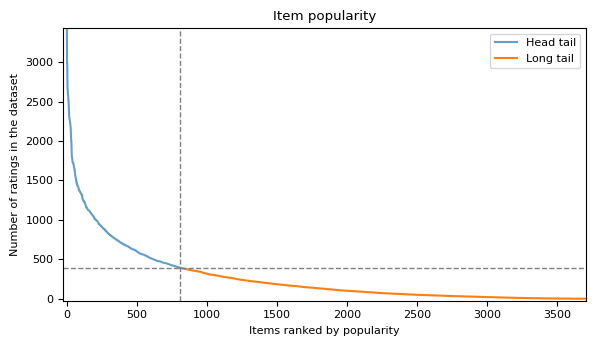

In [52]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(6, 3.5))

plt.title(r'Item popularity')
plt.xlabel('Items ranked by popularity')
plt.ylabel('Number of ratings in the dataset')
plt.plot(range(head_tail_split), item_pop.values[:head_tail_split], alpha=0.7, label=r'Head tail')
plt.plot(range(head_tail_split, len(item_pop.index)), item_pop.values[head_tail_split:], label=r'Long tail')
plt.axhline(y=item_pop.values[head_tail_split], linestyle='--', lw=1, c='grey')
plt.axvline(x=head_tail_split, linestyle='--', lw=1, c='grey')
plt.xlim([-25, len(item_pop.index)])
plt.ylim([-25, item_pop.values[0]])
plt.legend()
plt.tight_layout()

Please note how the curve is skewed towards items with only few ratings. In our case, most popular items are those receving more than 450 ratings. In the rest of this study, we will investigate how recommendation algorithms treat items belonging to these sets.

## Data analysis: popularity of the recommended items

We will use the same cutoffs we have configured in the first part.

**<font color='green'>IMPORTANT BOOKMARK</font>**: Please bookmark this point.

In [53]:
cutoffs = np.array([5, 10, 20])

In [55]:
model_types = ['utime_pairwise', 'utime_random', 'utime_mostpop']

To speed up, we will load the metrics pre-computed in the first notebook.

In [56]:
metrics = {}
for model_type in model_types:
    metrics[model_type] = load_obj(os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + model_type + '_metrics.pkl'))

First, we will compare the considered algorithms based on their recommendation effectiveness: `precision, recall, and NDCG`.

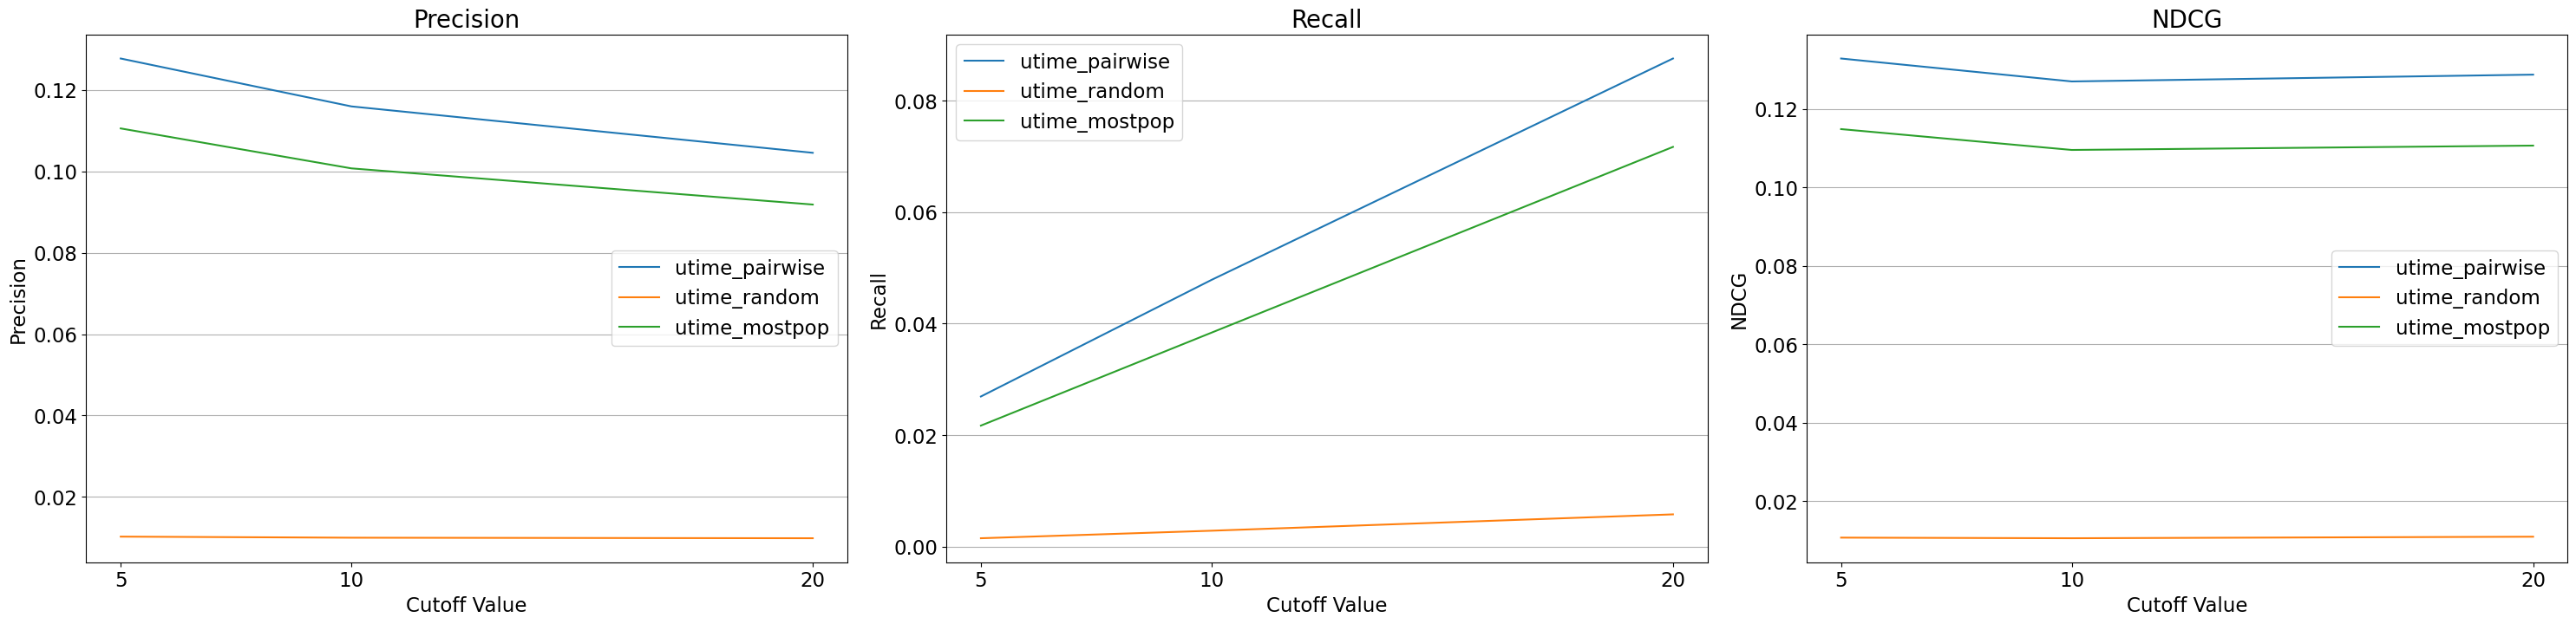

In [57]:
plt.rcParams.update({'font.size': 16.5})
plt.figure(figsize=(30, 7.5))

plt.subplot(131)
plt.title(r'Precision')
plt.xlabel('Cutoff Value')
plt.ylabel('Precision')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['precision'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.xticks(cutoffs)
plt.legend()
plt.grid(axis='y')

plt.subplot(132)
plt.title(r'Recall')
plt.xlabel('Cutoff Value')
plt.ylabel('Recall')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['recall'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.xticks(cutoffs)
plt.legend()
plt.grid(axis='y')

plt.subplot(133)
plt.title(r'NDCG')
plt.xlabel('Cutoff Value')
plt.ylabel('NDCG')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['ndcg'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.xticks(cutoffs)
plt.legend()
plt.grid(axis='y')

plt.tight_layout()

Please note that pairwise and mostpop algorithms have a really similar behavior for all the considered metrics. Now, we move our attention to the popularity of the recommended items and the coverage of the items we marked as "less popular".  

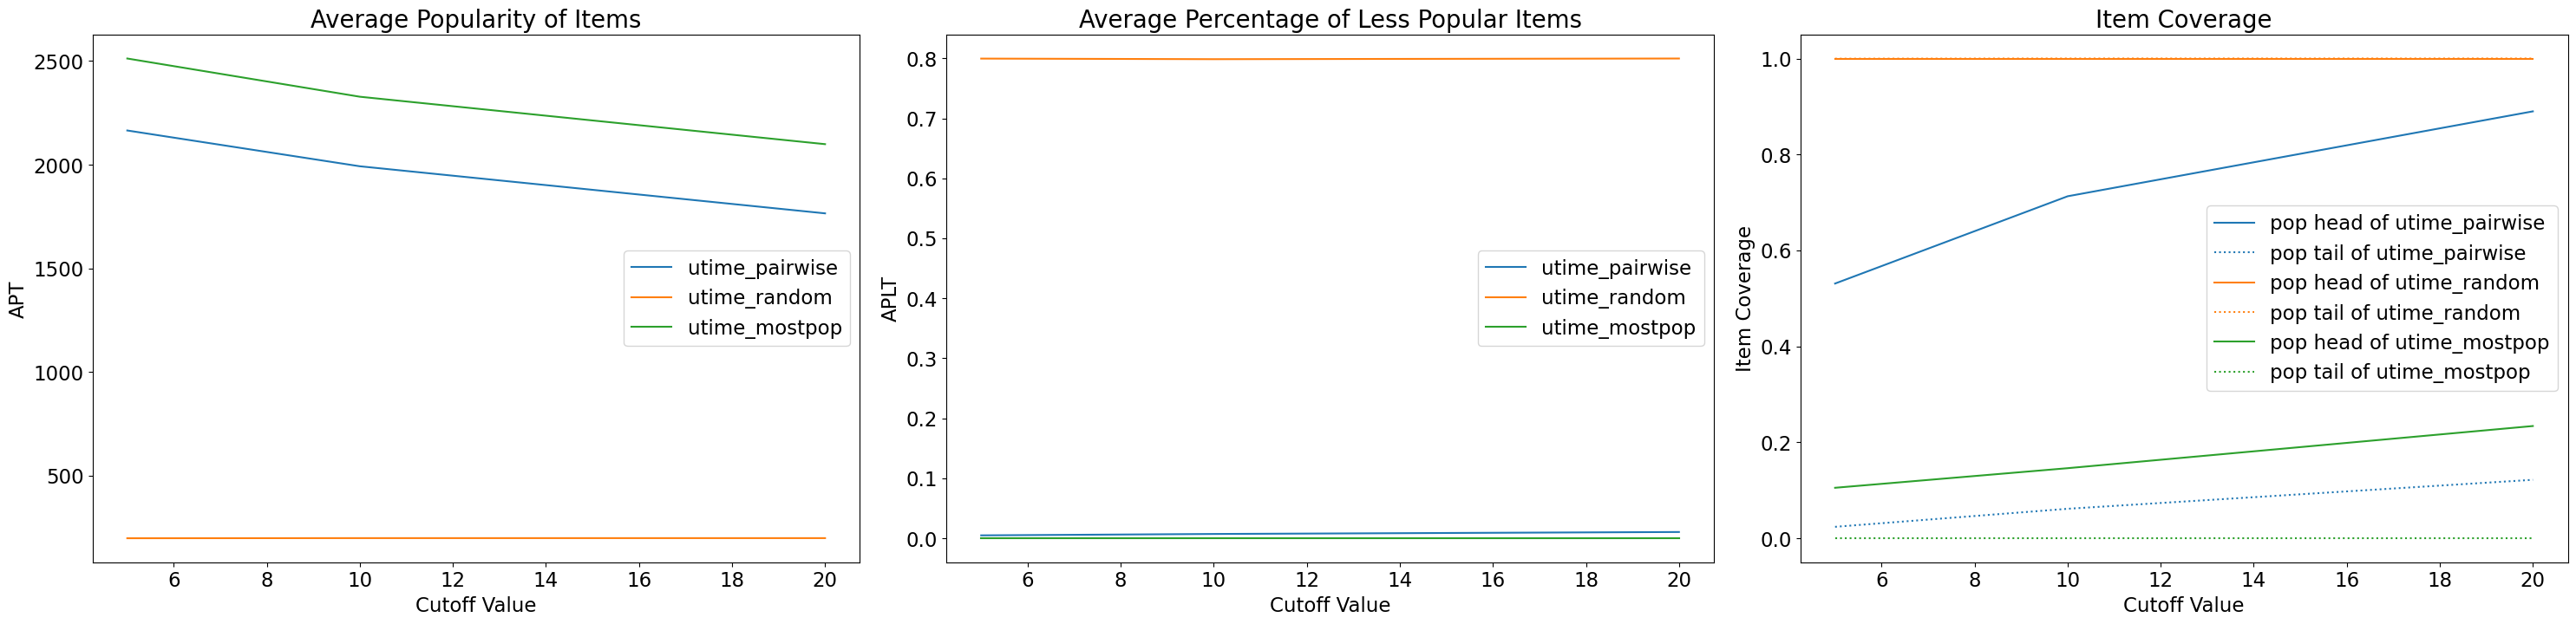

In [58]:
plt.rcParams.update({'font.size': 16.5})
plt.figure(figsize=(30, 7.5))

plt.subplot(131)
plt.title(r'Average Popularity of Items')
plt.xlabel('Cutoff Value')
plt.ylabel('APT')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['mean_popularity'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.legend()

plt.subplot(132)
plt.title(r'Average Percentage of Less Popular Items')
plt.xlabel('Cutoff Value')
plt.ylabel('APLT')
for model_type in model_types:
    plt.plot(cutoffs, [np.sum(metrics[model_type]['item_coverage'][k,long_tail_items]) / np.sum(metrics[model_type]['item_coverage'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.legend()

plt.subplot(133)
plt.title(r'Item Coverage')
plt.xlabel('Cutoff Value')
plt.ylabel('Item Coverage')
for i, model_type in enumerate(model_types):
    plt.plot(cutoffs, [len([1 for m in metrics[model_type]['item_coverage'][k,head_tail_items] if m > 0]) / len(head_tail_items) for k in range(len(cutoffs))], color='C'+str(i), linestyle='-', label='pop head of ' + model_type)
    plt.plot(cutoffs, [len([1 for m in metrics[model_type]['item_coverage'][k,long_tail_items] if m > 0]) / len(long_tail_items) for k in range(len(cutoffs))], color='C'+str(i), linestyle=':', label='pop tail of ' + model_type)
plt.legend()

plt.tight_layout()

These figures show us that the average popularity of items recommended by the pairwise algorithm is really high and not so far from the one of items recommended by mostpop. This observation is also confirmed by the coverage of items from the "less popular" set. For small cutoffs, pairwise and mostpop recommened only a tiny fraction of the less popular items.

## Sample treatment to promote less popular items: post-processing

In this part, we will show how to setup and perform a post-processing mitigation approach. We show a didactic version of the `xQuad algorithm` adaptation proposed by `Adbollahpouri et al. (2018)`. A model able to perform a re-ranking of the items has the same structure of the models we considered so far. Therefore, we first need to prepare all the data needed to initialize a model, as done in the first part.

In [59]:
traintest = pd.read_csv('../data/outputs/splits/' + dataset + '_' + smode + '.csv', encoding='utf8')

In [60]:
train = traintest[traintest['set']=='train'].copy()
test = traintest[traintest['set']=='test'].copy()

In [61]:
users = list(np.unique(traintest[user_field].values))
items = list(np.unique(traintest[item_field].values))

In [62]:
items_metadata = traintest.drop_duplicates(subset=['item_id'], keep='first')
category_per_item = items_metadata[type_field].values

Now, we are ready to import and use the re-ranking model mentioned above.

In [63]:
from models.ranker_xquad import RankerXQuad
model = RankerXQuad(users, items, train, test, category_per_item, item_field, user_field, rating_field)

Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics


In [64]:
original_model_type = 'utime_pairwise' # This string identifies the recommendation algorithm where the re-ranking is applied
reranked_model_type = original_model_type + '_' + 'xquad' # This string is an identifier for models results in data/outputs

We initialize the model predictions with those of the original recommendation model, precomputed in the first part.

In [65]:
predictions = load_obj(os.path.join(data_path,'outputs/predictions/' + dataset + '_' + original_model_type + '_scores.pkl'))

In [66]:
model.set_predictions(predictions)

Now, we can run the re-ranking process and save the positional relevance of items for users after re-ranking. Note, you can skip the following cells load directly our pre-computed re-ranking predictions. If you are going to run them please uncommet the following commands.

In [67]:
# model.rerank(type='smooth', lmbda=0.4, k=10, rmax=100, head_tail_split=head_tail_split)
# predictions = model.get_predictions()
# save_obj(predictions, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + reranked_model_type + '_scores.pkl'))

Finally, we compute and show the metrics for the recommender systems obtained after re-ranking.

In [68]:
# model.test(cutoffs)
# metrics = model.get_metrics()
# save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + reranked_model_type + '_metrics.h5'))

**To speed up**

This re-ranking takes several minutes. For this tutorial, please feel free to stop and load directly our pre-computed re-ranking predictions (2 MB).  

In [69]:
model.set_metrics(load_obj('../data/outputs/metrics/ml1m_utime_pairwise_xquad_metrics.pkl'))

In [70]:
model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

Precision: 0.1029 
Recall: 0.0491 
NDCG: 0.1167 
Hit Rate: 0.5207 
Avg Popularity: 1156.0285 
Category Diversity: 0.3287 
Novelty: 2.9771 
Item Coverage: 0.39 
User Coverage: 0.5207


Finally, we have obtained the metrics resulting from the considered strategy. Now, we come back to the **IMPORTANT BOOKMARK** mentioned above, using `cutoffs = np.array([5, 10])` and adding `utime_pairwise_xquad` to the `model_types` list. Then, we can rerun all the cells for plotting in order to compare the results obtained with these strategy against the ones of the baseline recommendation algorithms.

### Acknowledgement

- Abdollahpouri, Himan, Robin Burke, and Bamshad Mobasher. "Popularity-aware item weighting for long-tail recommendation." arXiv preprint arXiv:1802.05382 (2018).
- Rahmani, Hossein A., Mohammadmehdi Naghiaei, Mahdi Dehghan, and Mohammad Aliannejadi. "Experiments on generalizability of user-oriented fairness in recommender systems." In Proceedings of the 45th International ACM SIGIR Conference on Research and Development in Information Retrieval, pp. 2755-2764. 2022.
- This notebook is a midification of the following reposityry: https://github.com/biasinrecsys/umap2020
- Boratto, Ludovico, Gianni Fenu, and Mirko Marras. "The effect of algorithmic bias on recommender systems for massive open online courses." European Conference on Information Retrieval. Cham: Springer International Publishing, 2019.
- Boratto, Ludovico, Gianni Fenu, and Mirko Marras. "Connecting user and item perspectives in popularity debiasing for collaborative recommendation." Information Processing & Management 58.1 (2021): 102387.